# Risque Cardio-Vasculaires 

### Features :
* AGE:  integer (number of days)
* HEIGHT: integer (cm) 
* WEIGHT: integer (kg)
* GENDER: categorical (1: female, 2: male)
* AP_HIGH: systolic blood pressure, integer
* AP_LOW: diastolic blood pressure, integer 
* CHOLESTEROL: categorical (1: normal, 2: above normal, 3: well above normal)
* GLUCOSE: categorical (1: normal, 2: above normal, 3: well above normal)
* SMOKE: categorical (0: no, 1: yes)
* ALCOHOL: categorical (0: no, 1: yes)
* PHYSICAL_ACTIVITY: categorical (0: no, 1: yes)

## 1. Veille sur les Random Forest.

https://docs.google.com/document/d/1MsxgG7ZeCmQMk6hPPITBPFyq24ugcn9_rBwSdvtsZ5Q/edit

https://www.kaggle.com/emstrakhov/random-forest-feature-importances

## 2. Import

In [26]:
## lib générales
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')


### math
import numpy as np
import pandas as pd

### Autre
from collections import defaultdict
import time

### viz
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

## Sklearn
#### Preprossessing
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler
#### models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#### model selection / optimisation
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
#### Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer, roc_curve, auc, roc_auc_score, classification_report
####### Autres models ########
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [4]:
## Datas
df = pd.read_csv('./Datas/cardio_train.csv', sep=';', index_col=0)
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  
id                        
0      0       1       0  
1      0       1       1  
2      0       0       1  
3      0       1       1  
4      0       0       0

In [5]:
print(f"Chacune des colonnes possède {df.shape[0]} donnés non nulle.")
print("Sur ce jeu de donnée il n'est pas nécessaire d'effectuer de Feature engineering.")
df.info()

Chacune des colonnes possède 70000 donnés non nulle.
Sur ce jeu de donnée il n'est pas nécessaire d'effectuer de Feature engineering.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [6]:
df.describe()

age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   19468.865814      1.349571    164.359229     74.205690    128.817286   
std     2467.251667      0.476838      8.210126     14.395757    154.011419   
min    10798.000000      1.000000     55.000000     10.000000   -150.000000   
25%    17664.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      96.630414      1.366871      1.226457      0.088129      0.053771   
std      188.472530      0.680250      0.572270      0.283484      0.225568   
min      -70.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max    11000.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  70000.000000  70000.000000  
mean       0.803729      0.499700  
std        0.397179      0.500003  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

L'age étant indiqué en nombre de jours, il est nécessaire d'effectuer une modification pour obtenir des valeurs plus lisibles.

In [2]:
#df['age'] = round(df['age']/365.25, 0)
#df.head()

Finalement je me suis rendu compte que repasser en année diminue le Delta entre les donnée et induit une perte de performances (environ 1%) en terme de f1 score lors des prédictions avec l'algo random forest.


In [29]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Visualiser et analyser les données avec les librairies Matplotlib et Seaborn

<AxesSubplot:title={'center':'*Correlation map / critère : Pearson corr. coeff.* \n'}>

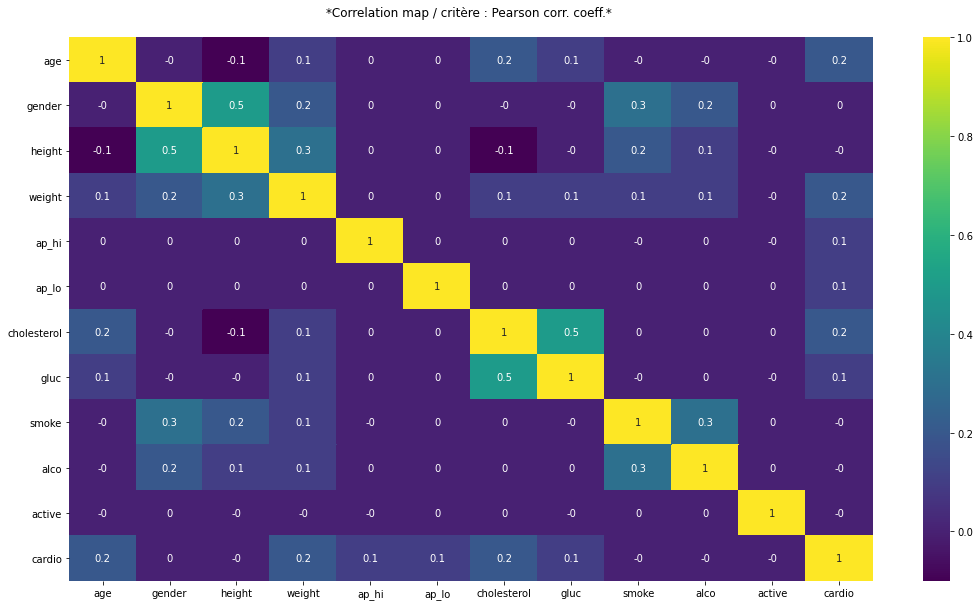

In [7]:
plt.figure(figsize=(18,10))
plt.title("*Correlation map / critère : Pearson corr. coeff.* \n")
sns.heatmap(df.corr().round(1),annot=True, cmap = 'viridis')

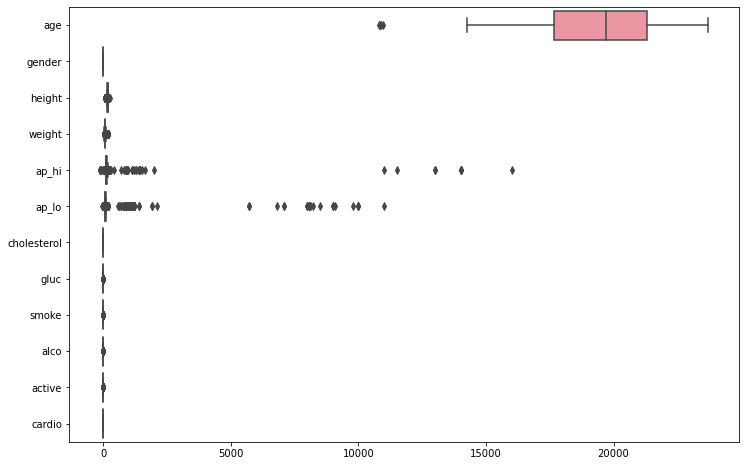

In [8]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=df, orient='h')

Outliers à écarter, ou du moins impact des outliers à quantifier

In [8]:
#df.drop(df[df.ap_hi > 5000].index, inplace=True)
#df.drop(df[df.ap_lo > 5000].index, inplace=True)

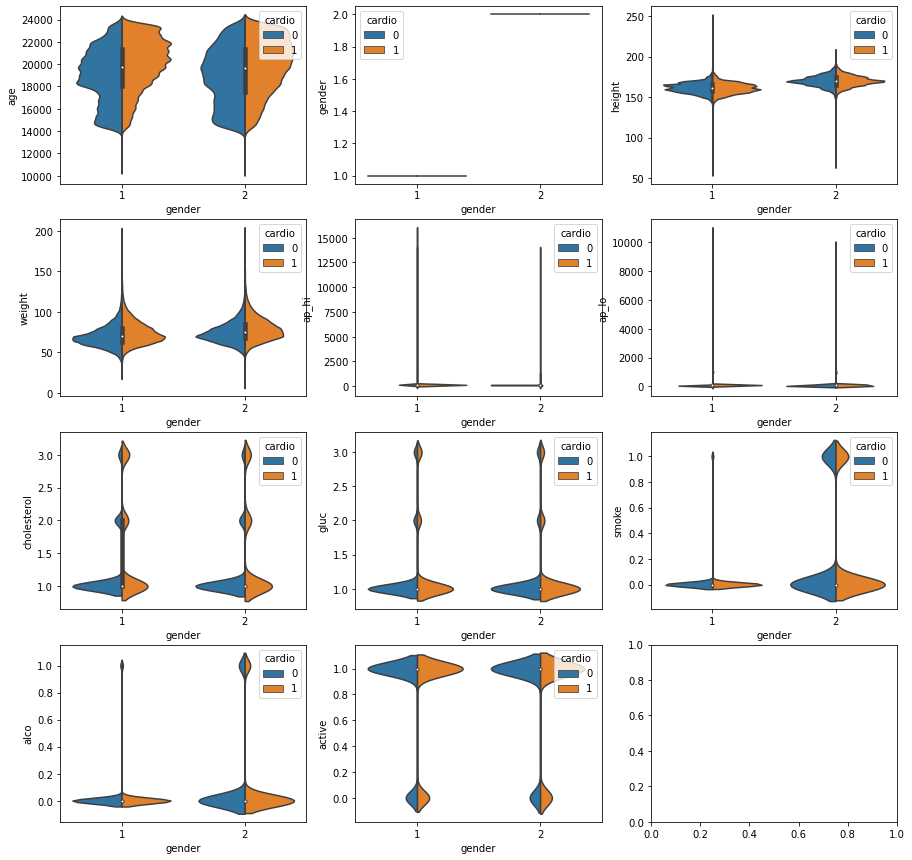

In [9]:
f, axes = plt.subplots(4, 3, figsize=(15, 15))
i = 0
for feature in df.columns[:-1]:
    sns.violinplot(data=df, y=feature, x='gender', hue='cardio', ax=axes[i//3, i%3], split=True)
    i+=1


A priori pas de réelle disparité dans les distributions pour la plupart des features entre les personnes à risque et non à risque.

Ormis pour l'age, qui parait être un critère influant.

## 4. Résoudre le cas d’étude présenté ci-dessus avec la librairie Scikit-Learn (exploration des données, préparation des données, modélisation, le test et l’interprétation des résultats).

In [9]:
## Matrice X
X = df.iloc[:,:-1].values # lasts column of data frame (not diagnosis)

## Vecteur cible y
y = df.cardio.values# column diagnosis of data frame 

Afin d'échantillonner les donné de manière "intelligente" nous utilisons StratifiedShuffleSplit qui maintient une répartition équitables des différentes classe dans le training et le testing set

In [10]:
rf = RandomForestClassifier()

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=12)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ## fit
    t0 = time.time()
    rf.fit(X_train, y_train)
    fit_time = time.time()- t0
    print(f"fit time {fit_time:.3f} secondes")
    
    ## Predict
    y_pred = rf.predict(X_test)
    
    ## Evaluation
    print(f"f1_score : {f1_score(y_test, y_pred)*100:.3f}")
    

fit time 7.471 secondes
f1_score : 71.172
fit time 7.146 secondes
f1_score : 70.812
fit time 7.036 secondes
f1_score : 71.591
fit time 7.036 secondes
f1_score : 70.835
fit time 7.261 secondes
f1_score : 71.385


### Interpretation des résultats

Text(0.5, 0, 'Relative Importance (%)')

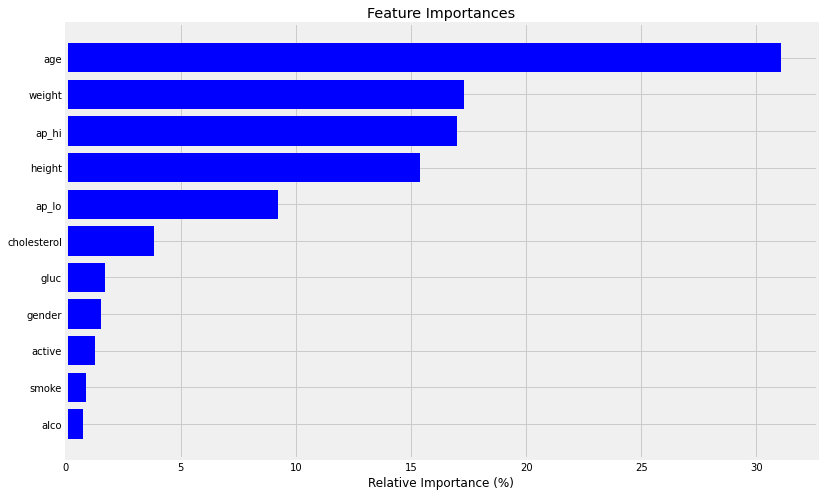

In [11]:
liste_variables = df.columns[:-1]
importances = rf.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices*100)), importances[indices]*100, color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance (%)')

FACTEURS D'IMPORTANCES : Age, Tension, Poids...

In [12]:
## Création du scorer
recall_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)

## affichage des paramètre 
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [30]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=12)

## grille de paramètres
grid_params = {
    'bootstrap' : ['True', 'False'],
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'criterion' : ['gini', 'entropy'],
    'class_weight' : ['balanced', 'balanced_subsample']
} 

gs = GridSearchCV(RandomForestClassifier(warm_start=True),
                  grid_params,
                  scoring=f1_scorer,
                  cv = sss,
                  n_jobs = -1
                 )

In [31]:
t0 = time.time()
gs_res = gs.fit(X, y)
fit_time = time.time()- t0

In [32]:
print(f"fit time : {fit_time} secondes")

fit time : 2165.397762298584 secondes


In [33]:
print('meilleur score obtenu :', gs_res.best_score_)
print('meilleur estimateur :', gs_res.best_estimator_)
print('meilleur paramètres :', gs_res.best_params_)

meilleur score obtenu : 0.7139952392923357
meilleur estimateur : RandomForestClassifier(bootstrap='False', class_weight='balanced',
                       n_estimators=250, warm_start=True)
meilleur paramètres : {'bootstrap': 'False', 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 250}


In [34]:
grid_params = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 50, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion' : ['gini', 'entropy'],
    'n_estimators': [50, 100, 200, 400, 800]
}

gs = GridSearchCV(RandomForestClassifier(warm_start=True),
                  grid_params,
                  scoring=f1_scorer,
                  cv = sss,
                  n_jobs = -1
                 )

In [ ]:
t0 = time.time()
gs_res = gs.fit(X, y)
fit_time = time.time()- t0

In [ ]:
print(f"fit time : {fit_time} secondes")

In [ ]:
print('meilleur score obtenu :', gs_res.best_score_)
print('meilleur estimateur :', gs_res.best_estimator_)
print('meilleur paramètres :', gs_res.best_params_)

In [13]:
def run_models(models, splits, X, y, size=0.2, seed=42): 
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=size, random_state=seed)
    for idx_train, idx_val in spliter.split(X, y):
        for model in models:
            
            # name of the model
            name = "-".join([x[0] for x in model.steps])
            
            # extract datasets
            X_train = X[idx_train]
            X_val = X[idx_val]
            y_train = y[idx_train]
            y_val = y[idx_val]
            
            # Learn
            t0 = time.time()
            model.fit(X_train, y_train)
            fit_time = time.time() - t0
            
            # predict and save results
            pred = model.predict(X_val)
            res[name].append([
                fit_time,
                f1_score(y_val, pred),  
                precision_score(y_val, pred),           
                recall_score(y_val, pred),           
            ])
    return res

def resultats(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time (s)" : [arr[:,0].mean().round(3), arr[:,0].std().round(3)],
            "f1_score": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "precision ": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
            "recall": [arr[:,3].mean().round(3), arr[:,3].std().round(3)]
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [14]:
model0 = Pipeline([
    ('Rand_fo', RandomForestClassifier(bootstrap='True', class_weight='balanced_subsample',
                       criterion='entropy', n_estimators=300, warm_start=True)),
])

model1 = Pipeline([
    ('MinMaxScal', MinMaxScaler()),
    ('Rand_fo', RandomForestClassifier(bootstrap='True', class_weight='balanced_subsample',
                       criterion='entropy', n_estimators=300, warm_start=True)),
])

model2 = Pipeline([
    ('StandScal', StandardScaler()),
    ('Rand_fo', RandomForestClassifier(bootstrap='True', class_weight='balanced_subsample',
                       criterion='entropy', n_estimators=300, warm_start=True)),
])

models = [model0, model1, model2]

In [15]:
print('shape of the global set (X, y):', X.shape, y.shape)
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state= 42)
print('shape of the rest set (X_rest, y_rest):', X_rest.shape, y_rest.shape)

shape of the global set (X, y): (70000, 11) (70000,)
shape of the rest set (X_rest, y_rest): (56000, 11) (56000,)


In [16]:
# run models
res = run_models(models, splits=10, X=X_rest, y=y_rest)

# print DataFrame Results
resultats(res)

time (s)        f1_score      precision   \
Rand_fo             [2.543, 7.618]  [0.921, 0.067]  [0.925, 0.065]   
MinMaxScal-Rand_fo  [2.373, 7.088]  [0.735, 0.074]  [0.797, 0.036]   
StandScal-Rand_fo   [2.401, 7.147]   [0.894, 0.06]  [0.922, 0.063]   

                            recall  
Rand_fo              [0.918, 0.07]  
MinMaxScal-Rand_fo  [0.688, 0.107]  
StandScal-Rand_fo   [0.868, 0.062]

L'impact d'une standardisation du jeu de données (minMax ou StadardScaler) est plutôt négatif sur les prédictions par rapport au modèle entreiné sur les données non standardisées.
### Sauvegarde du model pour son utilisation dans l'app flask

In [17]:
## sauvegarde
import pickle
filename = "model.pickle"
pickle.dump(model0, open(filename, 'wb'))

## 5. Prédire si Arthur 53 ans, fumeur, sportif, 175 cm, 85 kg, avec un taux de cholestérol au dessus de la normal et un taux de glucose normal, une tension artérielle systolique dans la moyenne et une pression sanguine diastolique correspondant à la moyenne du 3e quartile (50%-75%) du jeu de données, est un sujet à risques cardio-vasculaires.

In [18]:
def print_res(name, pred, prob):
    if pred == 0:
        print(f"D'après le modèle, {name} peux être considéré comme une personne avec peu")
        print(f"de risque d'avoir une maladie cardio-vasculaire (proba : {prob[0, 1].round(3)*100} %).")
    else:
        print(f"D'après le modèle, {name} peux être considéré comme une personne ayant")
        print(f"des risque de maladie cardio-vasculaire (proba : {prob[0, 1].round(3)*100} %).")

In [19]:
# masque pour selectionner les valeurs de pression sanguine diastolique correspondant auv3e quartile (50%-75%) 
mask = (df.ap_lo>=df.ap_lo.quantile(0.5)) & (df.ap_lo<=df.ap_lo.quantile(0.75))
X_Arthur = [[53*365.25, 2, 175, 85, df.ap_hi.mean(), df.ap_lo.loc[mask].mean(), 2, 1, 1, 1, 1]]

In [20]:
print("Prediction obtenus si Artur bois de l'alcool :")
Arthur_pred = model0.predict(X_Arthur)
Arthur_prob = model0.predict_proba(X_Arthur)

print_res('Arthur', Arthur_pred, Arthur_prob)

Prediction obtenus si Artur bois de l'alcool :
D'après le modèle, Arthur peux être considéré comme une personne avec peu
de risque d'avoir une maladie cardio-vasculaire (proba : 49.3 %).


In [21]:
X_Arthur = [[53*365.25, 2, 175, 85, df.ap_hi.mean(), df.ap_lo.loc[mask].mean(), 2, 1, 1, 0, 1]]
print("Prediction obtenus si Artur ne bois pas d'alcool :")
Arthur_pred = model0.predict(X_Arthur)
Arthur_prob = model0.predict_proba(X_Arthur)

print_res('Arthur', Arthur_pred, Arthur_prob)

Prediction obtenus si Artur ne bois pas d'alcool :
D'après le modèle, Arthur peux être considéré comme une personne avec peu
de risque d'avoir une maladie cardio-vasculaire (proba : 48.699999999999996 %).


On a vu dans l'analyse de l'importance des divers features que l'alcool est peu influant. Il semblerait même que dans l'exemple d'Arthur la consomation d'alcool ferait diminuer le risque de maladies cardio-vasculaire.

Il faut noter, tout de même que dans notre DataSet nous n'avons pas d'information sur la quantité d'alcool ni sur la fréquence.

Cependant cette conclusion corrobore certaines études sur le sujet :

https://www.revmed.ch/RMS/2010/RMS-239/Association-entre-consommation-d-alcool-et-facteurs-de-risque-cardiovasculaire-une-etude-sur-la-population-lausannoise#:~:text=L%27%C3%A9l%C3%A9va%20tion%20de%20la,niveaux%20de%20consommation%20d%27alcool

Cela peux être expliqué, dans la limite d'une consomation raisonnable, par le fait que la consommation d'alcool puisse faire baisser la pression artérielle ou augmente le taux de bon cholesterol!!! 

In [ ]:
'''
La consommation de plus de 13 unités/semaine est associée à une augmentation de la tension artérielle qui 
dépasse l’effet bénéfique de la hausse du HDL-cholestérol pour des con sommations importantes d’alcool.

Le vin semble avoir un effet plus favorable sur l’augmentation du HDL-cholestérol ; la bière et les 
spiritueux semblent être associés à une plus forte péjoration des taux de triglycérides.

L’effet cardioprotecteur d’une consommation modérée d’alcool disparaît probablement à plus forte dose.
'''

In [22]:
X_pers2 = [[57*365.25, 1, 170, 95, 125, 90, 2, 2, 0, 0, 0]]

Pers2_pred = model0.predict(X_pers2)
Pers2_prob = model0.predict_proba(X_pers2)
print_res('la personne', Pers2_pred, Pers2_prob)

D'après le modèle, la personne peux être considéré comme une personne ayant
des risque de maladie cardio-vasculaire (proba : 61.0 %).


## 6. Comparaison avec d'autres modèles
Le random forest étant une méthode d'ensemble il parrait pertinant de comparer en premier lieu avec d'autres algorithmes pris séparément et ensuite avec un modèle d'ensemble comprenant plusieurs autres modèles. 

-> Pas eu le temps, mon PC a tourné tout l'aprem sur un GridSearch résolument trop vaste...

Du coup j'ai fait une app Flask pendant ce temps

LinearSVC, SGDClassifier, LogisticRegression, KNeighborsClassifier

In [27]:
model3 = LinearSVC()
model4 = LogisticRegression()
model5 = KNeighborsClassifier()

In [ ]:
for model in (model1, model2, model3):
    model.fit(X_rest, y_rest)
    print(model.__class__.__name__, model.score(X_test, y_test))

In [ ]:
from sklearn.ensemble import StackingRegressor, BaggingClassifier
model6 = BaggingClassifier(base_estimator=LinearSVC()
                          n_estimator=100) 
model7 = BaggingClassifier(base_estimator=LogisticRegression()
                          n_estimator=100) 
model8 = BaggingClassifier(base_estimator=KNeighborsClassifier()
                          n_estimator=100) 

In [ ]:
model6.fit(X_rest, y_rest)
model6.score(X_test, y_test)

In [ ]:
model7.fit(X_rest, y_rest)
model7.score(X_test, y_test)

In [ ]:
model8.fit(X_rest, y_rest)
model8.score(X_test, y_test)